# [GOLIVE](https://nsidc.org/data/NSIDC-0710) glacier speed

This notebook proceeds in three parts to demonstrate working with the 
[**GOLIVE**](https://nsidc.org/data/NSIDC-0710)
dataset hosted by NSIDC. The first part covers obtaining the data. Part two deconstructs the data; 
and part three provides some visualization and analysis.


You can safely run the cells in sequence: Some cells (such as data ftp) are disabled using ```if False:```
and must be manually enabled. Some cells will rely on packages installed on the Port Cormorack Jupyter Hub;
so if you are working elsewhere you may find you need to do installations. Also please note that certain
digressive material is relegated to the companion notebook *golive_supplement*. 


## Part 1 Getting a dataset 

### Location: southeast Alaska, Landsat 8 Path 63 Row 18


This notebook is intended as a bootstrap tutorial on both the **GOLIVE** dataset and on the Python 
**xarray** package. The motivation is as follows: If we visualize time-series variations in glacier
speed (e.g. transects across the width of glacier) we may see variability suggestive of regional
forcing factors. 


> *Abstract*
>
> Region-wide increases in glacier speed should have discernible cause. This paper asks two related
> questions: For a time and location window provided by the GOLIVE dataset is speed variability of
> note and of interest? If so are there observations that might provide an interpretive basis?
> Temperate glaciers are known (citation...) to accelerate in spring with a corresponding infusion 
> of liquid water...
> 



Here is the [GoLIVE data selection interface](https://nsidc.org/app/golive) hosted at NSIDC.
We consider a set of glaciers in southeast Alaska over the period 2013 to present. Glacier ice is
found in gradually sloping valleys. It moves on the surface at speeds of typically a meter per day.


The source data are derived from repeated viewings. Landsat repeats its orbital track relative to 
a fixed point on the earth every 8 days. Comparisons of ice location are therefore possible over time
intervals of 8, 16, 24, 32, ... days. When the data support feature matching the results give surface
ice velocity in meters per day. Typically results will not be possible when the surface is obscured by
cloud. 


For more on Landsaat 8:


- [The Wikipedia entry for Landsat 8](https://en.wikipedia.org/wiki/Landsat_8)
- [The USGS description of Landsat 8](https://landsat.usgs.gov/landsat-8)
- [The NASA description of Landsat 8](https://landsat.gsfc.nasa.gov/landsat-8/mission-details/)



### NASA, GoLIVE and ITS LIVE


#### Summary

* NASA has a system called EOSDIS where datasets provided by domain centers called DAACs
* NSIDC hosts a cryosphere DAAC...
  * ...but the GOLIVE data are not technically 'within' the DAAC
  * ...rather GOLIVE is provided by NSIDC as a somewhat independent resource
* The DAACs in turn are unified under a NASA discovery mechanism called the Common Metadata Repository (CMR)
* The GOLIVE successor project ITSLIVE will be available through the CMR via affiliation with NASA MEaSUREs
  * More on [MEaSUREs](https://earthdata.nasa.gov/community/community-data-system-programs/measures-projects)
* Question: Can the geoscience community improve this machinery for discoverability and use?
  * Notebooks like this can help


#### Prolix


Question: The NASA CMR shows NSIDC as a DAAC with (Dec 2018) 343 collections (a fascinating list).
However GoLIVE is not among them. GoLIVE *ought* to be discoverable via CMR/GIBS; but the point will
be moot when ITSLIVE (a superset of GoLIVE) appears in CMR. Perhaps merely academic but why is
GOLIVE not discoverable in the CMR?
 
 
Answer: The current state of affairs is some mix of two factors. First there is no top-down mechanism in place 
to couple NASA machinery to Principle Investigator-supplied data (the case with Go LIVE). Second: A bottom-up
discoverability path to 'bespoke' datasets is also not established at the NASA DAAC.   


GoLIVE is novel as a data resource: A large-scale PI-sourced dataset processed at NSIDC and not *a priori*
connected to the NASA DAAC system. Anticipating this compatibility the data products *are* HDF5 netCDF4 cf 1.6
compliant. GoLIVE was funded as a NASA cryosphere research proposal: Successfully completed but with an 
indeterminate future. As of January 2019: There are nominal continuing costs associated with processing, storage
and access mechanisms for GoLIVE that are not resolved. 


The good news is that GoLIVE will be succeeded by a new 
[MEaSUREs](https://earthdata.nasa.gov/community/community-data-system-programs/measures-projects)
product called the Inter-Mission Time Series Land Ice Velocity and Elevation (ITSLIVE) project. 
**ITS LIVE** is just now entering its first year and will be a set of velocity and elevation 
products from many observing platforms.  Velocities will be produced, for example, from the complete 
available Landsat sequence (4,5,7, 8, possibly 9), and elevations will be produced from 
Synthetic Aperture Radars including Sentinal S1A/B/C/D.  Postings are registered to a common grid to 
facilitate time-series comparison across sensors. Via MEaSUREs this effort will incorporate into 
the NASA DAAC/EOSDIS structure.


To generalize we can ask: How does the NASA ensemble of DAACs accommodate the diverse
datasets produced by funded research; particularly those datasets created under non-NASA funding? 
How are these datasets made discoverable and accessible within the context of existing tools such as 
the python-cmr package? To hazard a normative remark: This would be a good time to address data access 
to facilitate insight into the near-future state of the earth system.


### The program here

In this notebook the procedure runs as follows:

* We know about GOLIVE *somehow*
* We arrive therefore at the map interface showing path/row blocks
* From one or more (Path + Row) pairs for a study site (they overlap) we get an ftp server URL
* We query that URL (here using Python) to list available png files and respective file sizes 
* Apply a file size criteria -- a proxy for how much good data is present -- to produce a 'download' list
* Download this data subset
* Deconstruct the NetCDF data files: Casting them into xarray Datasets/DataArrays 
* Consider some glacier transect speed profiles in time series


A tutorial notebook of this sort for each (of the thousands of) CMR-registered datasets would
be helpful: As a complement to social processes of expanding data access (hackweeks for example);
and defining a starting point for improving the access process.


This notebook attempts to follow a fairly direct narrative line. Digressive / supportive material are 
relegated to the **golive_supplement** companion notebook. For example some additional prefatory remarks 
can be found there in section ***S1***. Subsequent references will continue ***S2***, ***S3***, ...


In [1]:
# Some Python utility code
from pathlib import Path
home_d = str(Path.home()) + '/'
data_d = home_d + 'data/'             # A non-repository location for datasets of interest

def dirobj(obj): return [x for x in dir(obj) if not x.startswith('_')]

def lsal(path=''):
    import os
    return os.popen('ls -al ' + path).readlines()

def ShowGitHubImage(username, repo, folder, source, localpath, localname, width, height):
    global home_d
    import requests, shutil
    from PIL import Image
    outf = localpath + '/' + localname
    f = 'https://raw.githubusercontent.com/' + username + '/' + repo + '/master/' + folder + '/' + source
    a = requests.get(f, stream = True)
    if a.status_code == 200:
        with open(outf, 'wb') as f:
            a.raw.decode_content = True
            shutil.copyfileobj(a.raw, f)
    return Image.open(outf).resize((width,height),Image.ANTIALIAS)

def ShowLocalImage(path, filename, width, height):
    from PIL import Image
    f = path + '/' + filename 
    return Image.open(f).resize((width,height),Image.ANTIALIAS)

# Test either of the 'Show Image' functions
# ShowGitHubImage('robfatland', 'othermathclub', 'images/cellular', 'conus_textile_shell_2.png', home_d, 'ctextile.jpg', 450, 250)
# ShowLocalImage(home_d, 'ctextile.jpg', 450, 250)

In [2]:
# This cell looks in the ~/data/golive directory to list data files that have been downloaded
#   already. They are present due to prior efforts. If they are not present: Subsequent cells 
#   cover how to download them from NSIDC
golive_d = data_d + 'golive/'
fl = lsal(golive_d)
for f in fl: print(f.rstrip())

total 162432
drwxrwsr-x  2 jovyan users     4096 Dec 29 19:07 .
drwxrwsr-x 18 jovyan users     4096 Dec 29 19:06 ..
-rw-rw-r--  1 jovyan users 15512823 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.nc
-rw-rw-r--  1 jovyan users   310797 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.png
-rw-rw-r--  1 jovyan users  2716227 Dec 29 19:07 L8_063_018_016_2014_050_2014_066_v1.1.tif
-rw-rw-r--  1 jovyan users 15463469 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.nc
-rw-rw-r--  1 jovyan users   400154 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.png
-rw-rw-r--  1 jovyan users  2712915 Dec 29 19:07 L8_063_018_016_2014_066_2014_082_v1.1.tif
-rw-rw-r--  1 jovyan users 15637750 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.nc
-rw-rw-r--  1 jovyan users   358323 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.png
-rw-rw-r--  1 jovyan users  2712915 Dec 29 19:07 L8_063_018_016_2014_274_2014_290_v1.1.tif
-rw-rw-r--  1 jovyan users 15096375 Dec 29 19:07 L8_063_018_016_2015

In [3]:
# Run this cell to retrieve the data files from NSIDC
#   The golive_d local destination directory must already exist
#   Note that this cell does not run by default to keep the process intentional 
if False:
    
    # Let's fire up an ftp Client
    #   This allows us to connect anonymously to the GoLIVE server and get data.
    #   Running this cell may take a few minutes.
    from ftplib import FTP
    ftp = FTP('dtn.rc.colorado.edu')
    ftp.login()    # with no arguments this is a 'anonymous ftp'

    # I located this source data directory by using the GoLive browser interface; link is https://nsidc.org/app/golive
    # Path 64 row 18 or path 63 row 18 (a bit further east) both cover the Bering Glacier and associated. I will
    # stick with Path 63 as this also includes Malaspina.
    ftp.cwd('work/nsidc0710/nsidc0710_landsat8_golive_ice_velocity_v1.1/p063_r018')
    a=[]
    ftp.dir(a.append)    # This is a rather tricky line of Python as it passes an append method as an argument

    print(len(a), 'source files')             # expect 765+ entries... observed Dec 2018
    print(a[1].split())
    nFiles = len(a)
    nData = int(nFiles / 3)                   # we expect three files per dataset: .nc, .png and .tif in that order

    count = 0
    s = []
    for l in a:
        b = l.split()
        c = b[8].split('.')
        if c[-1] == 'png': s.append(int(b[4]))   # file size

    print('largest png image file is', int(max(s)/1000), 'MB (data volume vs no-data)')

    minPngSize = 300000                        # arbitrary cutoff for a decent amount of data
    for i in range(nData):
        print('considering file', i, 'of', nData, 'with png size', s[i])
        if s[i] > minPngSize:                  # imposes the requirement that source png file > minPngSize
            ncIndex = i*3                      #   files 0, 3, 6 etc will be the netcdf files we want 
            pngIndex = ncIndex + 1
            tifIndex = ncIndex + 2
            lineWeWant = a[ncIndex].split()
            fileWeWant = lineWeWant[8]
            print('considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)
    
            lineWeWant = a[pngIndex].split()
            fileWeWant = lineWeWant[8]
            print('    considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)    
    
            lineWeWant = a[tifIndex].split()
            fileWeWant = lineWeWant[8]
            print('    considering ' + fileWeWant)
            # ftp.retrlines('LIST ' + fileWeWant)
            ftp.retrbinary('RETR ' + fileWeWant, open(golive_d + fileWeWant, 'wb').write)    
    
    
    ftp.quit()
    

In [4]:
# This cell takes the data file names from a directory listing -> list f[] and also
#   catalogs the number of days interval for each dataset. This might be 16 or 32 for 
#   example, indicating that 16 or 32 days passed between successive Landsat 8 passes 
#   used to generate the velocity results.
fnc=[]
fpng=[]
ftif=[]
dur=[]
year=[]
doy=[]
for x in fl:
    sp = x.strip().split()
    if len(sp) == 9:
        if sp[8][-3:] == '.nc': 
            fnc.append(golive_d + sp[8])
            dur.append(int(fnc[-1].split('_')[3]))
            year.append(int(fnc[-1].split('_')[4]))
            doy.append(int(fnc[-1].split('_')[5]))
        elif sp[8][-4:] == '.png': 
            fpng.append(golive_d + sp[8])
        elif sp[8][-4:] == '.tif':
            ftif.append(golive_d + sp[8])
        else: 
            print('non-data file noticed:', sp[8])
            
print('Here are the first three files:')
print('  ', fnc[0])
print('  ', fpng[0])
print('  ', ftif[0])
print('...from year', year[0], 'day', doy[0])

non-data file noticed: .
non-data file noticed: ..
Here are the first three files:
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.nc
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.png
   /home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.tif
...from year 2014 day 50


year 2014 day 274


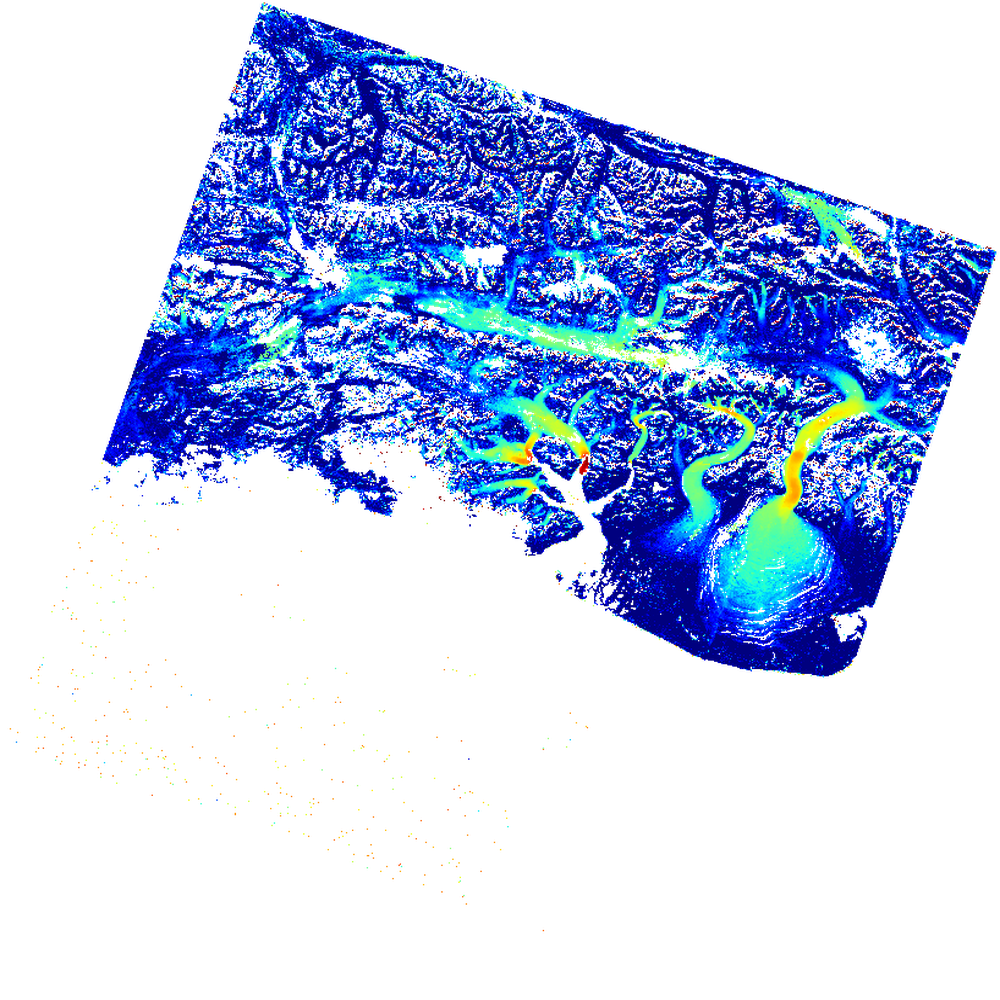

In [5]:
# This uses the .png file. Can substitute the .tif file; and in this case it appears identical
index = 2                   # from the observation that there is a lot of good data in the third file
print('year', year[index], 'day', doy[index])
ShowLocalImage('', fpng[index], 1000, 1000)

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import xarray as xr
import numpy as np

In [78]:
print(fnc[0])                # print the first NetCDF data file name
# filename structure:
#   LANDSAT8 = L8_
#   Path = 063_ is a choice of orbital imaging track
#   Row = 018_ is a choice of cell along that track: path + row gives source image
#   Delta time = 016_... the number of days separating the two source images
#   Year_DOY of first image in pair 2014_050_
#   Year_DOY of second image in pair 2014_066_
#   Version of the motion tracking software 'v1.1'

/home/jovyan/data/golive/L8_063_018_016_2014_050_2014_066_v1.1.nc


In [79]:
# As of December 2018 we see 6 16-day-repeat pairs available
#   There is nothing a priori special about 16-day intervals but just to reduce the considered data volume
#   in a first pass we ignore the other datasets in what follows. 

n16s = dur.count(16)    # counts occurrences of '16' in the day-duration list

m = [xr.open_mfdataset(f) for f in fnc if int(f.split('_')[3]) == 16]
year = [f.split('_')[4] for f in fnc if int(f.split('_')[3]) == 16]
doy = [f.split('_')[5] for f in fnc if int(f.split('_')[3]) == 16]
    
print('there are', n16s, '16-day-interval velocity grids in the m[] list')
print(year)
print(doy)

# We now have Xarray datasets m[0], m[1], ... , m[5] with a decent number of good values

there are 6 16-day-interval velocity grids in the m[] list
['2014', '2014', '2014', '2015', '2016', '2018']
['050', '066', '274', '341', '136', '253']


## Part 2 Data access


This section explores the NetCDF files now as a list of **xarray** DataSets m[]
for the 16-day-interval results. How can we deconstruct each DataSet into usable numbers 
(glacier speeds for example).

- Dates involved?
- Coordinates? 
- Data units? Density? Quality? Retrieve velocity profiles at a particular location?
- How do we avoid considering bad data as good data? 
- How to build a time-series visualization?


To begin with simply naming the DataSet produces a nice text description.

In [80]:
m[0]

<xarray.Dataset>
Dimensions:                                         (chars: 4284, x: 819, y: 828)
Coordinates:
  * x                                               (x) float64 3.331e+05 ...
  * y                                               (y) float64 6.786e+06 ...
  * chars                                           (chars) int32 0 1 2 3 4 ...
Data variables:
    image_pair_times                                |S1 ...
    input_image_details                             |S1 ...
    transverse_mercator                             |S1 ...
    offset_correction                               |S1 ...
    applied_bilinear_x_offset_correction_in_pixels  (y, x) float32 dask.array<shape=(828, 819), chunksize=(828, 819)>
    applied_bilinear_y_offset_correction_in_pixels  (y, x) float32 dask.array<shape=(828, 819), chunksize=(828, 819)>
    vx                                              (y, x) float32 dask.array<shape=(828, 819), chunksize=(828, 819)>
    vy                                    

### Interpretation

From the above we see the data are in (y, x) transverse mercator coordinates (meters). That is
to say there will be a y-coordinate in a two-dimensional DataArray which is **northing** and an
x-coordinate which is **easting**. 


Velocities will be in meters per day. They are available in both unmasked and masked format, where
it is probably safe to assume that the mask reduces spurious results. 


For more interpretation / exploration remarks see **S2** in the *golive_supplement* notebook.


### Location and UTM basics

Seward Glacier is the main ice feed into the Malaspina (piedmont lobe) glacier. Within this dataset it 
is consistently one of the fastest 'good signal' regions. It flows along a sinuous track from north to south on the 
eastern side of the image.  A 'good data' location on this glacier is latitude 60.15 deg N, longitude -140.45 deg W.


Let's get the [UTM coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system)
for this location and then reverse that to verify lat/lon.

In [81]:
# noticing that the data are in UTM
!pip install utm
import utm

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [82]:
# This gives us Northing, Easting, longitudinal band 7, and latitude band 'V'
#   There are 60 longitude bands, each 6 degrees; and 20 latitude bands, each 8 degrees.
#   For a few additional pathologies please see the Wikipedia article referenced above.
utm.from_latlon(60.15, -140.45)

(530538.5079323711, 6668243.670375315, 7, 'V')

In [83]:
utm.to_latlon(530538.5079323711, 6668243.670375315, 7, 'V')

(60.150000005547355, -140.44999999728375)

### Further exploratory on m\[\]

The 'directory' function dir(object) gives an extensive view into **object**. For more on this see **S3** 
in golive_supplement. 


In what follows we look at the same three pixels across four Data variables.

In [84]:
print(m[0]['vv'][493,650:653].values)             # straightforward speeds
print(m[0]['vv_masked'][493,650:653].values)      # masked speeds
print(m[0]['corr'][493,650:653].values)           # correlation values for the speed calculation
print(m[0]['lgo_mask'][493,650:653].values)       # mask values

[18.035414 28.27528  28.256655]
[18.035414       nan       nan]
[0.5504157  0.35188547 0.47261477]
[0. 0. 0.]


* 18 meters per day glacier speed in southeast Alaska is suspiciously fast
* The masking process catches bad values for pixels 2 and 3 but not 1
* As shown below the mask uses '0' for glacier, '1' for non-glacier and '2' for ocean

[[1. 1. 1. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


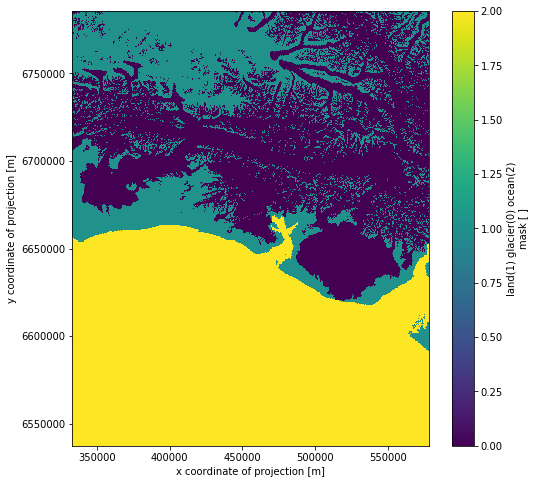

In [14]:
print(m[0]['lgo_mask'][0:5,0:5].values)
m[0].lgo_mask.plot(figsize=(8,8))

(6630000, 6694000)

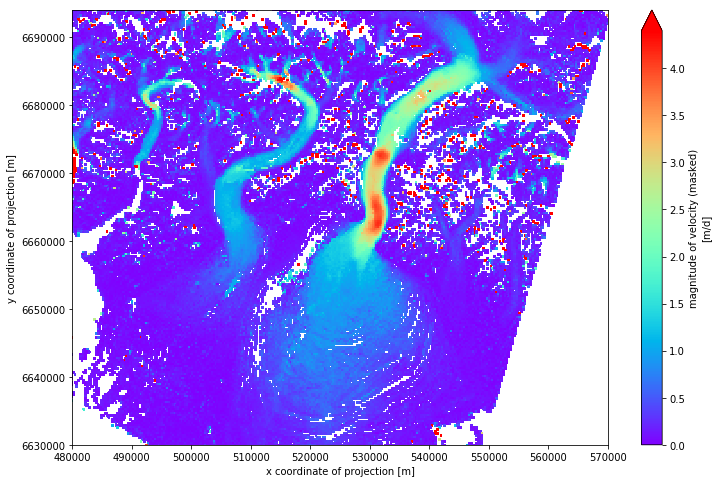

In [86]:
# The y's are in the 6.6 million range, the x's are in the 500,000 range.
# A little trial-and-error produced the following cropped view of speeds around Malaspina/Seward/Agassiz Glaciers
minSpeed, maxSpeed = 0.0, 4.4
m[2].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=minSpeed, vmax=maxSpeed) # rainbow > bwr blue-white-red

# focus on the interesting part of the image...
plt.xlim(480000,570000)
plt.ylim(6630000,6694000)

### Time manipulation

In [16]:
m[2]['image_pair_times']

<xarray.DataArray 'image_pair_times' ()>
array(b'', dtype='|S1')
Attributes:
    del_t:                    16.0
    del_t_units:              days
    del_t_speed_units:        m/d
    start_time_decimal_year:  2014.74794521
    mid_time_decimal_year:    2014.76986301
    end_time_decimal_year:    2014.79178082
    start_date:               2014-10-01T00:00:00
    mid_date:                 2014-10-09T00:00:00
    end_date:                 2014-10-17T00:00:00

In [17]:
# ok let's just get the start_date attribute
m[2]['image_pair_times'].start_date

'2014-10-01T00:00:00'

In [18]:
# For time: Python datetimes work via conversion using 'string parse time' abbreviated 'strptime'
from datetime import datetime
d0 = datetime.strptime(m[2]['image_pair_times'].start_date, '%Y-%m-%dT%H:%M:%S')
d1 = datetime.strptime(m[2]['image_pair_times'].end_date, '%Y-%m-%dT%H:%M:%S')
print(d0)
print(d1)
print('interval is', d1 - d0)

2014-10-01 00:00:00
2014-10-17 00:00:00
interval is 16 days, 0:00:00


#### ipyleaflet map

The following sets up a map that can be used for example to generate transects or regions of interest. 

In [122]:
print(ftif[2])

/home/jovyan/data/golive/L8_063_018_016_2014_274_2014_290_v1.1.tif


In [142]:
import os, gdal

out_path = golive_d + 'tiles/'
output_filename = 'tile_'

tile_size_x = 256
tile_size_y = 256

ds = gdal.Open(ftif[2])
band = ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

for i in range(0, xsize, tile_size_x):
    for j in range(0, ysize, tile_size_y):
        com_string = "gdal_translate -of GTIFF -srcwin " + str(i)+ ", " + str(j) + \
            ", " + str(tile_size_x) + ", " + str(tile_size_y) + " " + ftif[2] + " " + \
            str(out_path) + str(output_filename) + str(i) + "_" + str(j) + ".tif"
        os.system(com_string)

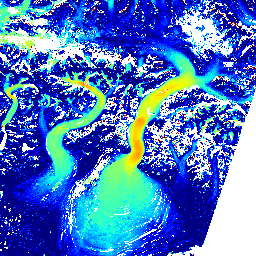

In [143]:
ShowLocalImage('', '/home/jovyan/data/golive/tiles/tile_512_256.tif', 256, 256)

In [185]:
from ipyleaflet import WMSLayer
from ipyleaflet import (Map, Marker, MarkerCluster,
    TileLayer, ImageOverlay, Polyline, Polygon, Rectangle, Circle, CircleMarker,
    Popup, GeoJSON, DrawControl, basemaps, Velocity, basemap_to_tiles)

from ipywidgets import Label

# The native map layer has admirable resolution down to building outlines
gmap = Map(center=(60.2, -141.211), zoom=8)

# This abandons the native map:
# gmap.clear_layers()

# This defines the working zoom levels (I believe)
# gmap.interact(zoom=(4,15,1))

# This adds a map layer with less resolution but it features both shaded relief and iso elevation lines
# gmap.add_layer(basemaps.Esri.DeLorme)

# An example of creating a Web Mapping Service map layer
# ...roads, water bodies, and buildings 
# wms = WMSLayer(url='https://ows.terrestris.de/osm/service', layers='OSM-Overlay-WMS', tile_size=512)
# gmap.add_layer(wms)

# io = ImageOverlay(url=ftif[2], bounds=m.bounds)
# gmap.add_layer(io)
# g = GeoJSON(data=ftif[2])
# velocity = Velocity(data=m[2])

# This works quite well...
# nasa_layer = basemap_to_tiles(basemaps.NASAGIBS.ModisTerraTrueColorCR, "2018-04-08");
# gmap.add_layer(nasa_layer);

In [186]:
# imageoverlay = ImageOverlay(url='file:/'+fpng[2], bounds=gmap.bounds)
# print(imageoverlay)
# gmap.add_layer(imageoverlay)

tilelayer = TileLayer(url='file:/'+golive_d+'/tiles/')
gmap.add_layer(tilelayer)


In [187]:
gmap

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [173]:
# See golive_supplement S5 for more on labels
label = Label('----coordinates on map----'); display(label)
def handle_interaction(**kwargs): label.value = str(kwargs.get('coordinates'))    
gmap.on_interaction(handle_interaction)

Label(value='----coordinates on map----')

### Concluding part 2

Have...

* a map 
* coordinate access (utm conversion)
* data mask
* time  
* time series of both data (velocities) and correlation quality
  * speed-as-temperature plot

Need...

* indexing by nearest coordinates 
* a handle on xarray DataSet / DataArray manipulation
  * cf [this Geohackweek link](https://geohackweek.github.io/nDarrays/02-xarray-architecture/)
  * emphasis: xarray DataArrays are extensions of the numpy nDarray n-dimensional array. 
    * 'Extension' in the sense that they have labeled dimensions and coordinates. 
    * gets away from indexing arrays by integers: 0, 1, ..., dim-1.
  * and cf [xarray DataArray official documentation](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)


With respect to xarray DataArrays we have five components: ```x.dims, x.values, x.coords, x.name, x.attrs```

- dims
- values
- coords
- name
- attrs is an ordered dictionary of metadata


## Part 3 data visualization and analysis


This section tries to connect interpretive thinking to data access. We begin with a
look at the .nearest() method and then return to the **utm** package tools to convert a transect in
lat/lon defined by endpoints into a set of time-series speed transects.

In [117]:
northing = 6637657.5
easting = 528142.5
a = m[2]['vv_masked'].sel(y=northing, x=easting, method='nearest')
# a = m[0]['vv_masked'].sel(y=northing, x=easting)
a.values

TypeError: 'Map' object does not support indexing

In [66]:
# some transects on Seward Glacier and a longitudinal transect across Malaspina piedmont
#   These coordinates were determined by hand; it would be much better to implement a nice map control
#   to generate them using a point/click interface. 

SewardTransEndpoints = []
MalaspinaEndpoints = []

SewardTransEndpoints.append(((60.104166,-140.478055),(60.079166,-140.421944)))
SewardTransEndpoints.append(((60.150833,-140.494444),(60.14611,-140.400277)))
SewardTransEndpoints.append(((60.189722,-140.456388),(60.17083,-140.389722)))
SewardTransEndpoints.append(((60.242222,-140.417500),(60.21805,-140.300277)))

MalaspinaEndpoints.append(((60.066388,-140.510555),(59.726944,-140.580555)))

seward_utm0 = []
seward_utm1 = []
malaspina_utm0 = []
malaspina_utm1 = []
for i in range(4):
    seward_utm0.append(utm.from_latlon(SewardTransEndpoints[i][0][0],SewardTransEndpoints[i][0][1]))
    seward_utm1.append(utm.from_latlon(SewardTransEndpoints[i][1][0],SewardTransEndpoints[i][1][1]))

malaspina_utm0.append(utm.from_latlon(MalaspinaEndpoints[0][0][0],MalaspinaEndpoints[0][0][1]))
malaspina_utm1.append(utm.from_latlon(MalaspinaEndpoints[0][1][0],MalaspinaEndpoints[0][1][1]))

# So utm0 is a UTM 4-plet, as is utm1, for the two endpoints of the transect

# The transects are about 5 to 40 km in length. With nominal 240 meter posting in the data we'll 
#   oversample a bit via 100 meter postings
from numpy.linalg import norm
posting = 100.

# S = Seward Gl; tr = transect vector across the glacier; tl = transect length; tp = posting-length transect vector
trS = [(seward_utm1[i][0]-seward_utm0[i][0], seward_utm1[i][1]-seward_utm0[i][1]) for i in range(4)]
tlS = [norm(trS[i]) for i in range(4)]
tpS = [trS[i]/tlS[i]*posting for i in range(4)]
npS = [int(tlS[i]/posting) + 1 for i in range(4)]

trM = [(malaspina_utm1[0][0]-malaspina_utm0[0][0], malaspina_utm1[0][1]-malaspina_utm0[0][1])]
tlM = [norm(trM[0])]
tpM = [trM[0]/tlM[0]*posting]
npM = [int(tlM[0]/posting) + 1]


print(seward_utm0, '\n')       # notice these 4-tuples are (easting, northing, lon-band, lat-band)
print(trS, '\n')
print(tlS, '\n')
print(tpS, '\n')
print(npS, '\n')
print(trM, '\n')
print(tlM, '\n')
print(tpM, '\n')
print(npM, '\n')

[(529021.1110697987, 6663126.611153034, 7, 'V'), (528070.0981115395, 6668316.724012578, 7, 'V'), (530147.4105949326, 6672664.497006416, 7, 'V'), (532252.417105228, 6678529.731215285, 7, 'V')] 

[(3144.1744930562563, -2758.1968929581344), (5233.141818051343, -482.24623928405344), (3716.5123229203746, -2071.6535719921812), (6518.903660722659, -2628.9233719613403)] 

[4182.521170670804, 5255.314902376576, 4254.904507596729, 7029.03571149186] 

[array([ 75.17414413, -65.94579634]), array([99.57808267, -9.17635286]), array([ 87.3465507 , -48.68860319]), array([ 92.74250307, -37.40091073])] 

[42, 53, 43, 71] 

[(-3657.135517305869, -37828.78888074588)] 

[38005.156339317735] 

[array([ -9.6227351 , -99.53593808])] 

[381] 



In [67]:
s, d = [], []

for t in range(4):
    s.append([float(m[2]['vv_masked'].sel(y=seward_utm0[t][1] + float(i)*tpS[t][1], 
                                   x=seward_utm0[t][0] + float(i)*tpS[t][0], 
                                   method='nearest').values) for i in range(npS[t])])
    d.append([float(i)*posting for i in range(npS[t])])

# Malaspina (presently only one longitudinal profile)
for t in range(1):
    s.append([float(m[2]['vv_masked'].sel(y=malaspina_utm0[t][1] + float(i)*tpM[t][1], 
                                x=malaspina_utm0[t][0] + float(i)*tpM[t][0], 
                                method='nearest').values) for i in range(npM[t])])
    d.append([float(i)*posting for i in range(npM[t])])

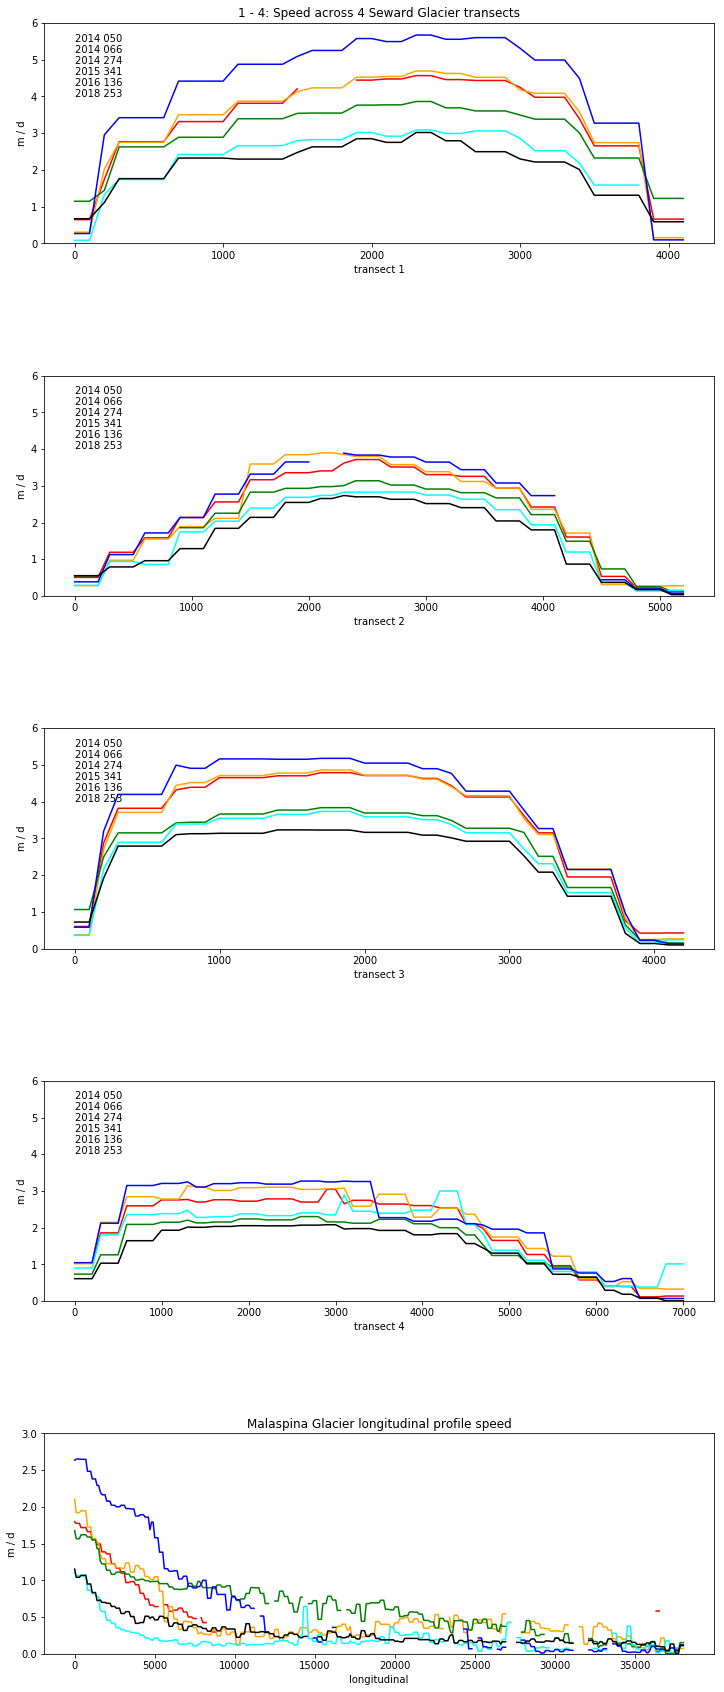

In [68]:
# Remember that n16s is how many 16-day-interval results we have; and these are m[0], ..., m[n16s - 1]
colorsequence = ['red', 'orange', 'green', 'cyan', 'blue', 'black']
fig,axes = plt.subplots(5, figsize=(1,1))
fig.set_size_inches(12,30)
# Don't need axes[0].axis('equal') as this is not geometry
axes[0].set(ylim=(0., 6.))
axes[1].set(ylim=(0., 6.))
axes[2].set(ylim=(0., 6.))
axes[3].set(ylim=(0., 6.))
axes[4].set(ylim=(0., 3.))
axes[0].set(xlabel='transect 1', ylabel = 'm / d', title='1 - 4: Speed across 4 Seward Glacier transects')
axes[1].set(xlabel='transect 2', ylabel = 'm / d')
axes[2].set(xlabel='transect 3', ylabel = 'm / d')
axes[3].set(xlabel='transect 4', ylabel = 'm / d')
axes[4].set(xlabel='longitudinal', ylabel = 'm / d', title='Malaspina Glacier longitudinal profile speed')
# plt.subplots_adjust(bottom=-.2, top=1.2)
plt.subplots_adjust(hspace=0.6)
# plot(x-list, y-list)
x = []
y = []


for t in range(4):                           # loop over the sub-plots
    for j in range(n16s):                    # for each one loop over the number of 
        s = [float(m[j]['vv_masked'].sel(y=seward_utm0[t][1] + float(i)*tpS[t][1], 
                                   x=seward_utm0[t][0] + float(i)*tpS[t][0], 
                                   method='nearest').values) for i in range(npS[t])]
        d = [float(i)*posting for i in range(npS[t])]
        axes[t].plot(d, s, color=colorsequence[j])

for j in range(n16s):                    # for each one loop over the number of 
    s = [float(m[j]['vv_masked'].sel(y=malaspina_utm0[0][1] + float(i)*tpM[0][1], 
                x=malaspina_utm0[0][0] + float(i)*tpM[0][0], 
                method='nearest').values) for i in range(npM[0])]
    d = [float(i)*posting for i in range(npM[0])]
    axes[4].plot(d, s, color=colorsequence[j])

xoff=[]
for t in range(4):
    for j in range(n16s):
        axes[t].text(0, 5.5 - 0.3*j, str(year[j]) + ' ' + str(doy[j]))
    
# s.append([float(m[2]['vv_masked'].sel(y=seward_utm0[t][1] + float(i)*tpS[t][1], 
#                       x=seward_utm0[t][0] + float(i)*tpS[t][0], 
#                       method='nearest').values) for i in range(npS[t])])
# d.append([float(i)*posting for i in range(npS[t])])



In [69]:
northing = 6637657.5
easting = 528142.5
a = m[2]['vv_masked'].sel(y=northing, x=easting, method='nearest')
# a = m[0]['vv_masked'].sel(y=northing, x=easting)
a.values

array(0.62025964)

(6630000, 6694000)

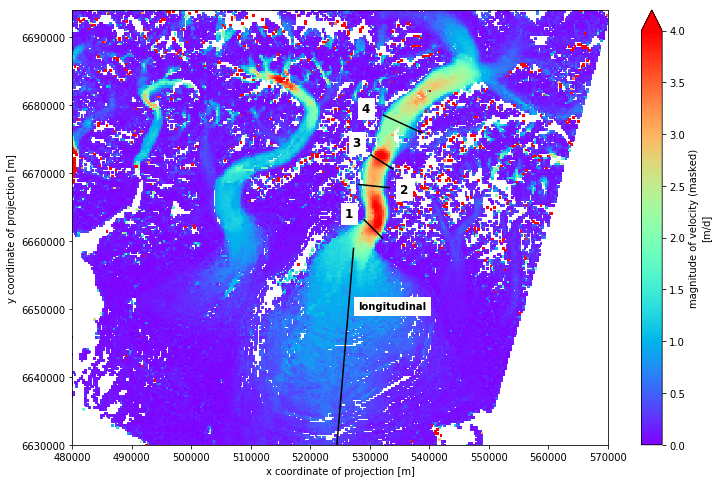

In [91]:
# Now let's confirm the transects are where we think they are
#   Working from http://xarray.pydata.org/en/stable/auto_gallery/plot_cartopy_facetgrid.html
#   which provides 'how to overlay content on an xarray.plot()'
p = m[2].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=0.0, vmax=4.0) # rainbow > bwr blue-white-red
ax = p.axes

# the first index is the transect index: 0, 1, 2, 3
for j in range(4): 
    xxx = [seward_utm0[j][0] + float(i)*tpS[j][0] for i in range(npS[j])]
    yyy = [seward_utm0[j][1] + float(i)*tpS[j][1] for i in range(npS[j])]
    ax.plot(xxx, yyy, 'k')

xxx = [malaspina_utm0[0][0] + float(i)*tpM[0][0] for i in range(npM[0])]
yyy = [malaspina_utm0[0][1] + float(i)*tpM[0][1] for i in range(npM[0])]
ax.plot(xxx, yyy, 'k')
ax.text(525800, 6663500, '1', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
ax.text(535000, 6667000, '2', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
ax.text(527100, 6674000, '3', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
ax.text(528600, 6679000, '4', fontsize = '12', color='black', backgroundcolor='white', weight='bold')
ax.text(528000, 6650000, 'longitudinal', fontsize = '10', color='black', backgroundcolor='white', weight='bold')


# focus on the interesting part of the image...
plt.xlim(480000,570000)
plt.ylim(6630000,6694000)

In [92]:
# dir(ax)

In [93]:
# At this point it is good to remember 
# I will compile a list of (x, y) tuples where the velocity is reasonable
#   so I am in effect masking the mask. 
min_good = 0.5
max_good = 10.0
good=[]

# This obvious nested loop approach is *very* slow but it does seem to work
# Notice it is commented out because there must be a faster way
# for j in range(300): # the 828 y-coordinate 
#     for i in range(300): # the 819 x-coordinate
#         s = m[0]['vv_masked'][j,i].values
#         if s >= min_good and s <= max_good:
#             good.append((j, i))

# This loop is instructive because it prints 819 twice meaning that it loops over the y-index 
#   and generates a list of the x values. I comment it out to move on to the next test.
# count = 0
# for speed in m[0]['vv_masked'][:]:    ...or equivalently...
# for speed in m[0]['vv_masked']:
#     print(len(speed.values))
#     count += 1
#     if count > 1: break

# count = 0
# for row in m[0]['vv_masked']:
#     for entry in row:
#         if entry.values >= min_good and entry.values <= max_good:
#             print(entry.values, entry.get_index('x'), entry['y'].values)
#             count += 1
#         if count > 0: break
#     if count > 0: break

# xr.where(m[0]['vv_masked'].values > min_good and m[0]['vv_masked'].values < max_good, good.append('fubar'))
# a = m[0]['vv_masked'].values.sel(values > min_good)

# >>> a = xr.DataArray(np.arange(25).reshape(5, 5), dims=('x', 'y'))
a = m[0]['vv_masked']
b = a.where((a > min_good) & (a < max_good))
print(b)
b.plot
# print(count)
# print(len(good))
# good

<xarray.DataArray 'vv_masked' (y: 828, x: 819)>
dask.array<shape=(828, 819), dtype=float32, chunksize=(828, 819)>
Coordinates:
  * x        (x) float64 3.331e+05 3.334e+05 3.337e+05 3.34e+05 3.343e+05 ...
  * y        (y) float64 6.786e+06 6.785e+06 6.785e+06 6.785e+06 6.784e+06 ...
Attributes:
    grid_mapping:   transverse_mercator
    standard_name:  speed_masked
    long_name:      magnitude of velocity (masked)
    units:          m/d
    masking_info:   masked_where(((del_corr_arr<0.100)&(corr_arr<1.000))|(cor...


In [94]:
good_copy=list(good)

In [95]:
for i in range(50):
    print(m[0]['vv_masked'][good[i]].values)

IndexError: list index out of range

(array([38718., 45083., 25252., 13770.,  7999.,  5519.,  4162.,  2674.,
         1917.,  1403.,  1104.,   974.,   666.,   535.,   479.,   410.,
          360.,   271.,   239.,   179.,   177.,   178.,   173.,   173.,
          196.,   227.,   226.,   178.,   172.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
        1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
        2.6, 2.7, 2.8, 2.9]),
 <a list of 29 Patch objects>)

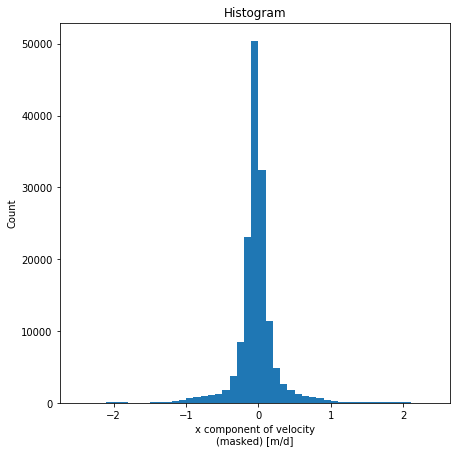

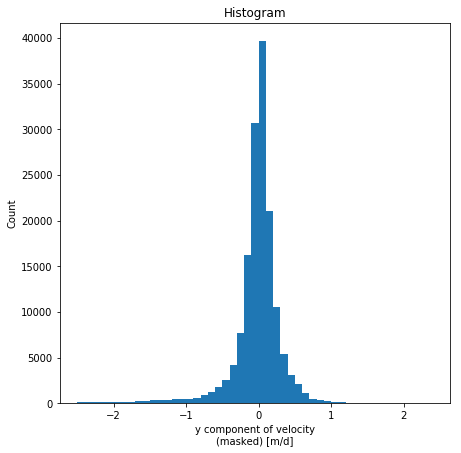

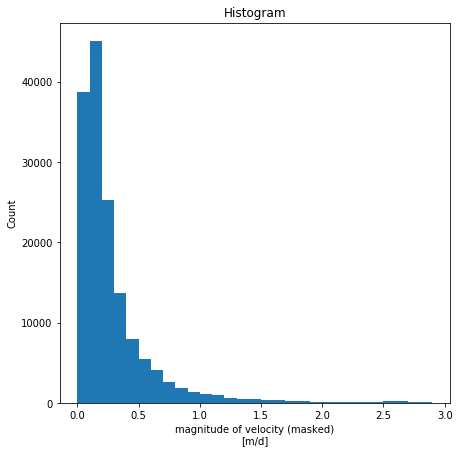

In [96]:
hist_increment = 0.10
x0 = -2.5
x1 = 2.5
s0 = 0.0
s1 = 3.0
m[0].vx_masked.plot.hist(figsize=(7,7),bins=np.arange(x0,x1,hist_increment))
m[0].vy_masked.plot.hist(figsize=(7,7),bins=np.arange(x0,x1,hist_increment))
m[0].vv_masked.plot.hist(figsize=(7,7),bins=np.arange(s0,s1,hist_increment))

(6658000, 6715000)

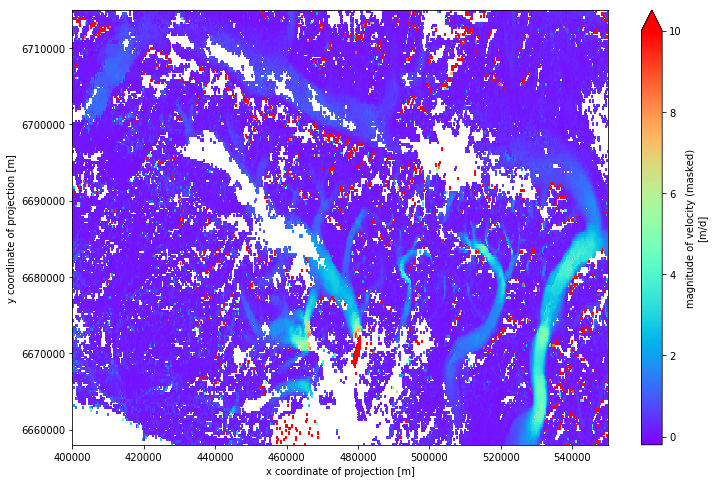

In [97]:
m[0].vv_masked.plot(figsize=(12,8),cmap=plt.cm.rainbow,vmin=-.2, vmax=10.) # over bwr blue-white-red
plt.xlim(400000,550000)
plt.ylim(6658000,6715000)


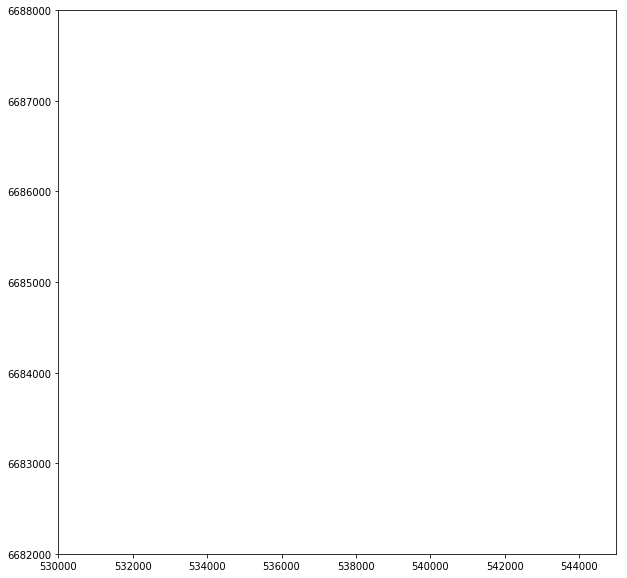

In [98]:
# from ShowCurrents(date_index)
X, Y = np.meshgrid(m[0]['y'], m[0]['x'])
U = m[0]['vy']
V = m[0]['vx']
plt.figure(figsize=(10,10))
plt.xlim(530000,545000)
plt.ylim(6682000,6688000)
# plt.title('ice velocities')
thisFigure = plt.quiver(X, Y, U, V, units='width')